#### 1) Reproduce the PRISM precipitation anomaly maps for each WT 
#### 2) Precipitation Seasonal anomaly
 

In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)

from coexist_func import cal_season_cli_prism
from coexist_func import ax_coastlines_country
from coexist_func import cal_season_ano_prism
from coexist_func import plot_prec_12

weather types are from <br>
/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT  <br>
Produced by: AssignToExistingWTs_ERA_INTERIM.ipynb

In [2]:
# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 6
lat_e = DATA['rgrLatWT'].max() + 2
lon_s = DATA['rgrLonWT'].min()  
lon_e = DATA['rgrLonWT'].max() + 6
print('lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

season_dict = {
    'DJF': [12,1,2],
    'MAM': [3,4,5],
    'JJA': [6,7,8],
    'SON': [9,10,11],
    'JAS': [7,8,9]}

n_season = len(season_dict)
n_season = 4

year_s = 1981
year_e = 2014
n_year = year_e - year_s + 1

n_wt = 12


lat: 24.75 - 50.0 lon: -125.25 - -64.5


In [3]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/'
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/'
 
dir_wt = '/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT/'

#### calculate prec climatology

In [5]:
flnm_nc = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc'

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    with  xr.open_dataset(flnm_nc) as ds_prec:
        prec_mean = ds_prec.PR
        
else:  
    is_first = True
    for year in range(year_s, year_e+1, 1):
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e)).mean(dim='time')
            #print(prec)
                
            if is_first == True:
                data_all = prec.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec], dim='time')
                           
    print(data_all.shape)
    prec_mean = data_all.mean(dim='time')
    prec_mean.to_netcdf( path = flnm_nc)    

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc exist


In [6]:
lat = prec_mean.rlat
lon = prec_mean.rlon
n_lat = prec_mean.shape[0]
n_lon = prec_mean.shape[1]

#### precipitation anomalies of WTs

In [7]:
prec_3d = np.zeros((n_wt, n_lat, n_lon))

flnm_prec = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc'
if os.path.isfile(flnm_prec):
    print(flnm_prec, 'exist')
    with  xr.open_dataset(flnm_prec) as ds:
        prec_xr = ds.__xarray_dataarray_variable__
else:
  for nw in range(n_wt):
    is_first = True
    for year in range(year_s, year_e+1, 1):
        StartDay = datetime.datetime(year,  1, 1,  0)
        EndDay   = datetime.datetime(year, 12, 31,  0)
        TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
        # read WT file
        flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) +'.cla'
        print(flnm_wt)
            
        wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
        wts_g = wts.groupby(['wt']) 
        g_ind = wts_g.get_group(nw+1).index
            
        # read PRISM file
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
            
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e))
            prec_wt = prec[g_ind,:,:]
            # check time coordinates associated with WT
            #print(prec_wt)
                
            if is_first == True:
                data_all = prec_wt.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec_wt.copy()], dim='time')
                #print(data_all.shape)
    print(data_all.shape)                
    prec_3d[nw] = data_all.mean("time") 
        
  prec_xr = xr.DataArray(prec_3d, 
                       coords={'lat':prec_mean.rlat, 'lon': prec_mean.rlon, 'wt':range(n_wt)},
                       dims=["wt", "rlat", "rlon"])
 
  prec_xr.to_netcdf(path = flnm_prec)             
  print(flnm_prec)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc exist


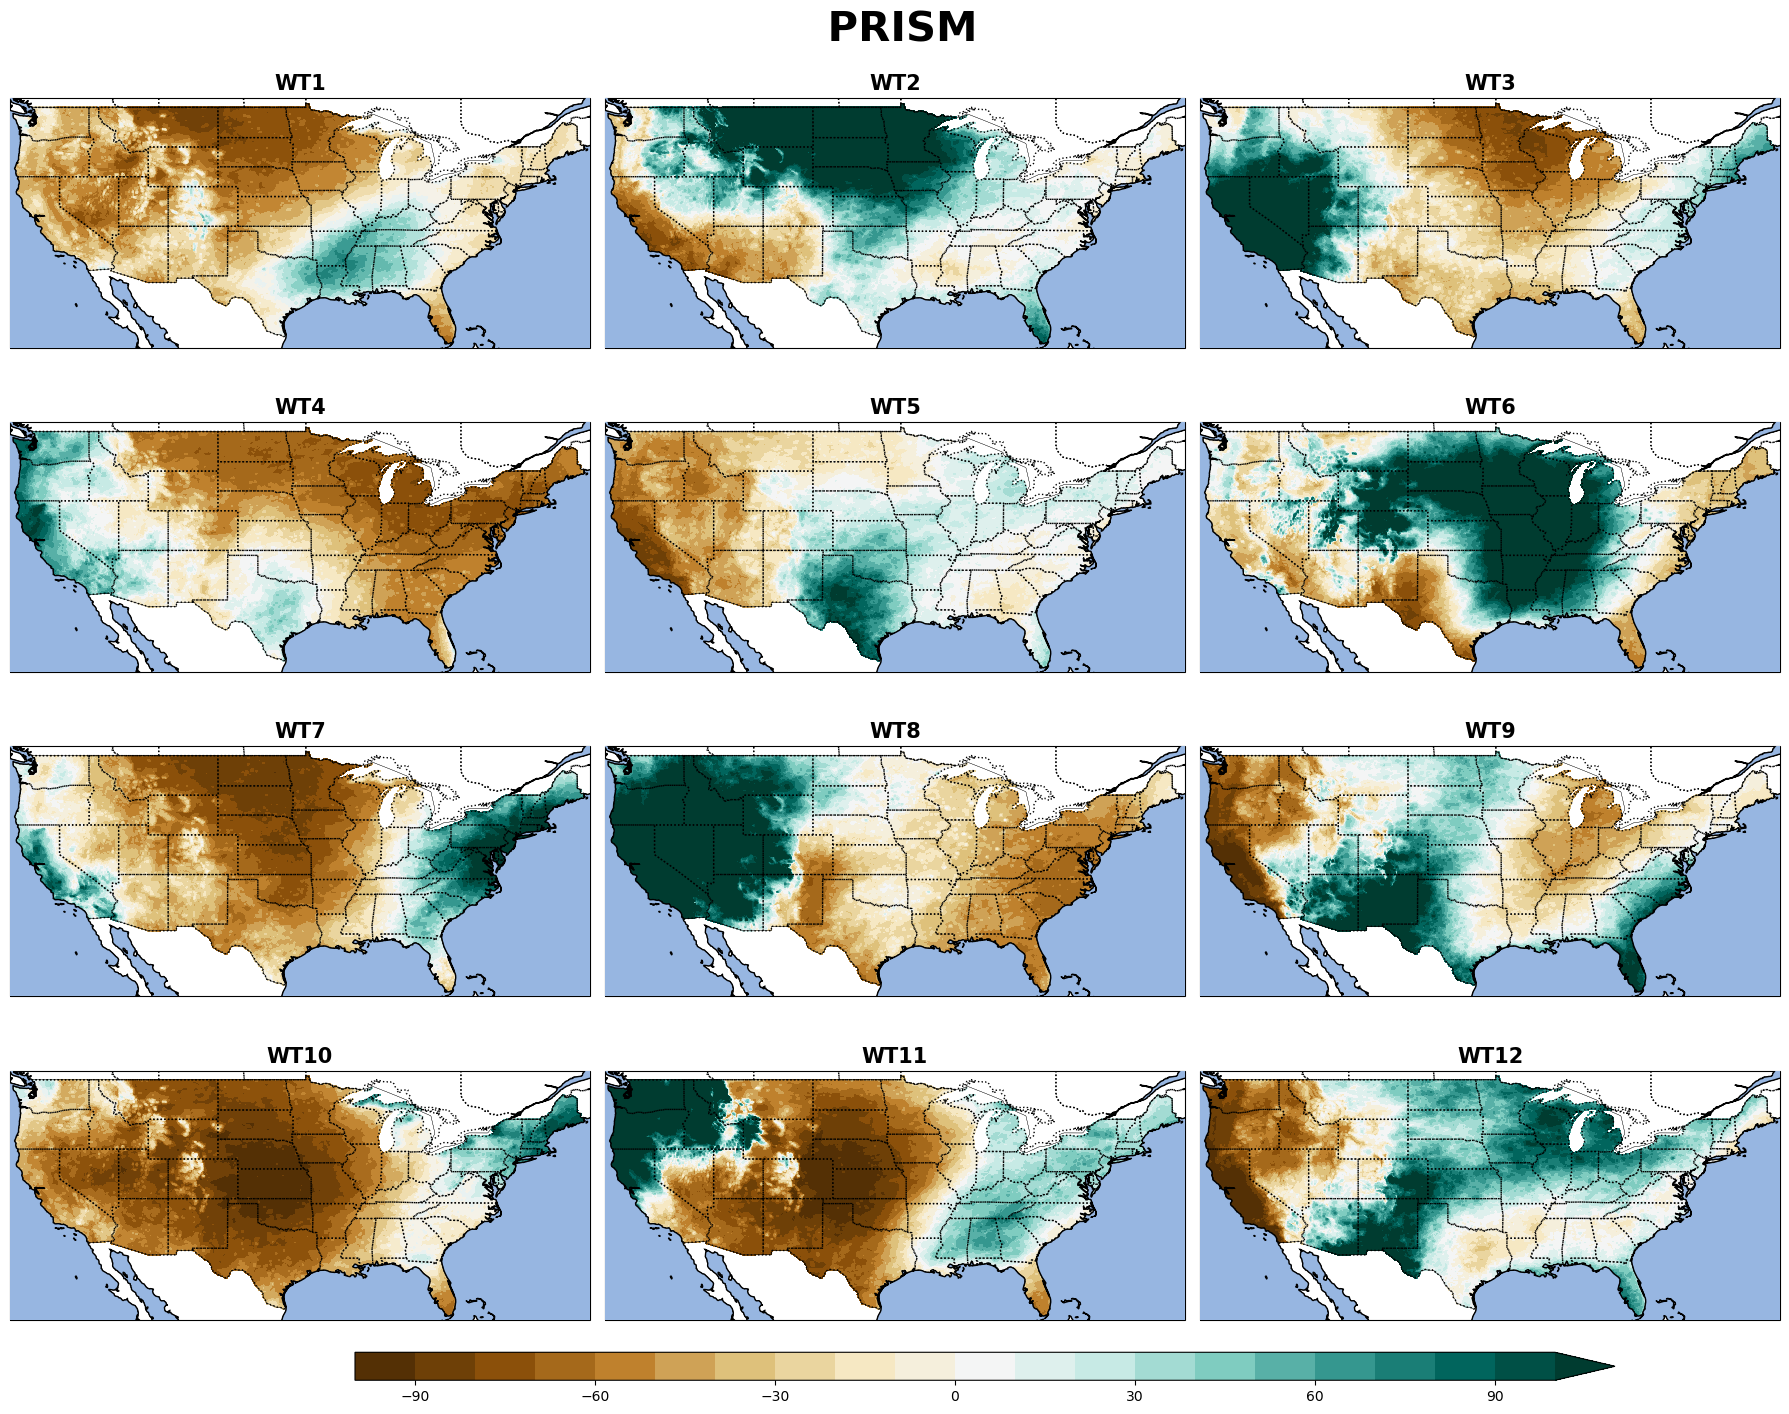

In [8]:
prec_avg = (prec_xr - prec_mean)/prec_mean*100
plot_prec_12(prec_avg, -100, 100, 21, 'BrBG', 'horizontal', 'PRISM') 

#### 2 Precipitation Seasonal anomaly
 - 2.1) seasonal climatology

In [12]:
flnm_cli = dir_o + 'prec_seasonal_cli.nc'
prec_cli_xr = cal_season_cli_prism('PR', dir_prism, season_dict, year_s, year_e, lat, lon, lat_s, lat_e, lon_s, lon_e, flnm_cli)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_seasonal_cli.nc exist
Frozen({'rlat': 605, 'rlon': 1405, 'season': 4})


 - 2.2) seasonal anomaly

In [13]:
flnm_cli = dir_o + 'prec_seasonal_cli.nc'
flnm_o = dir_o + 'prec_seasonal_ano.nc'
cal_season_ano_prism('PR', dir_prism, dir_wt, season_dict, year_s, year_e, lat, lon, lat_s, lat_e, lon_s, lon_e, flnm_cli, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_seasonal_ano.nc exist


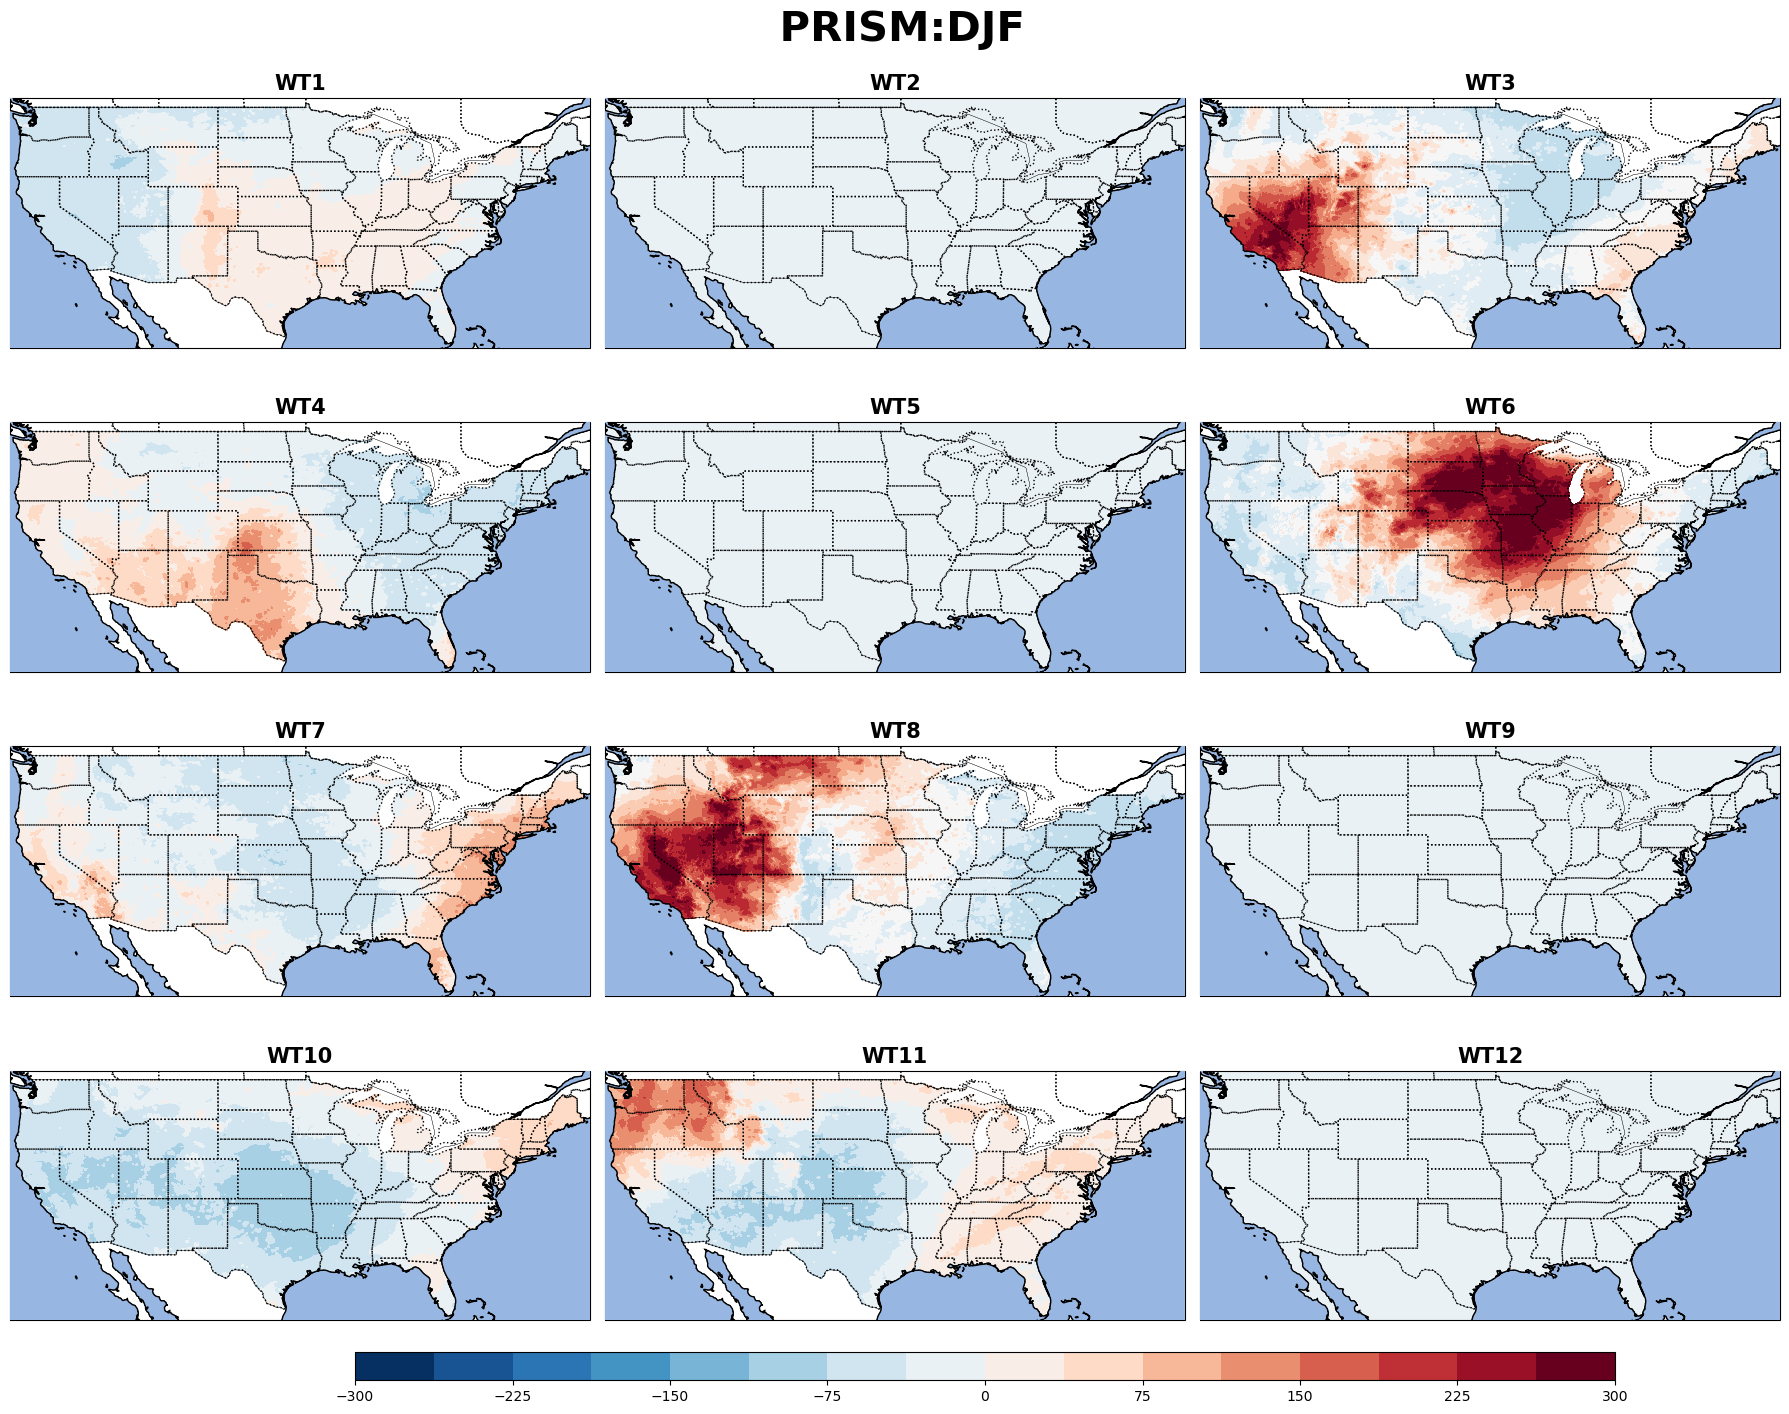

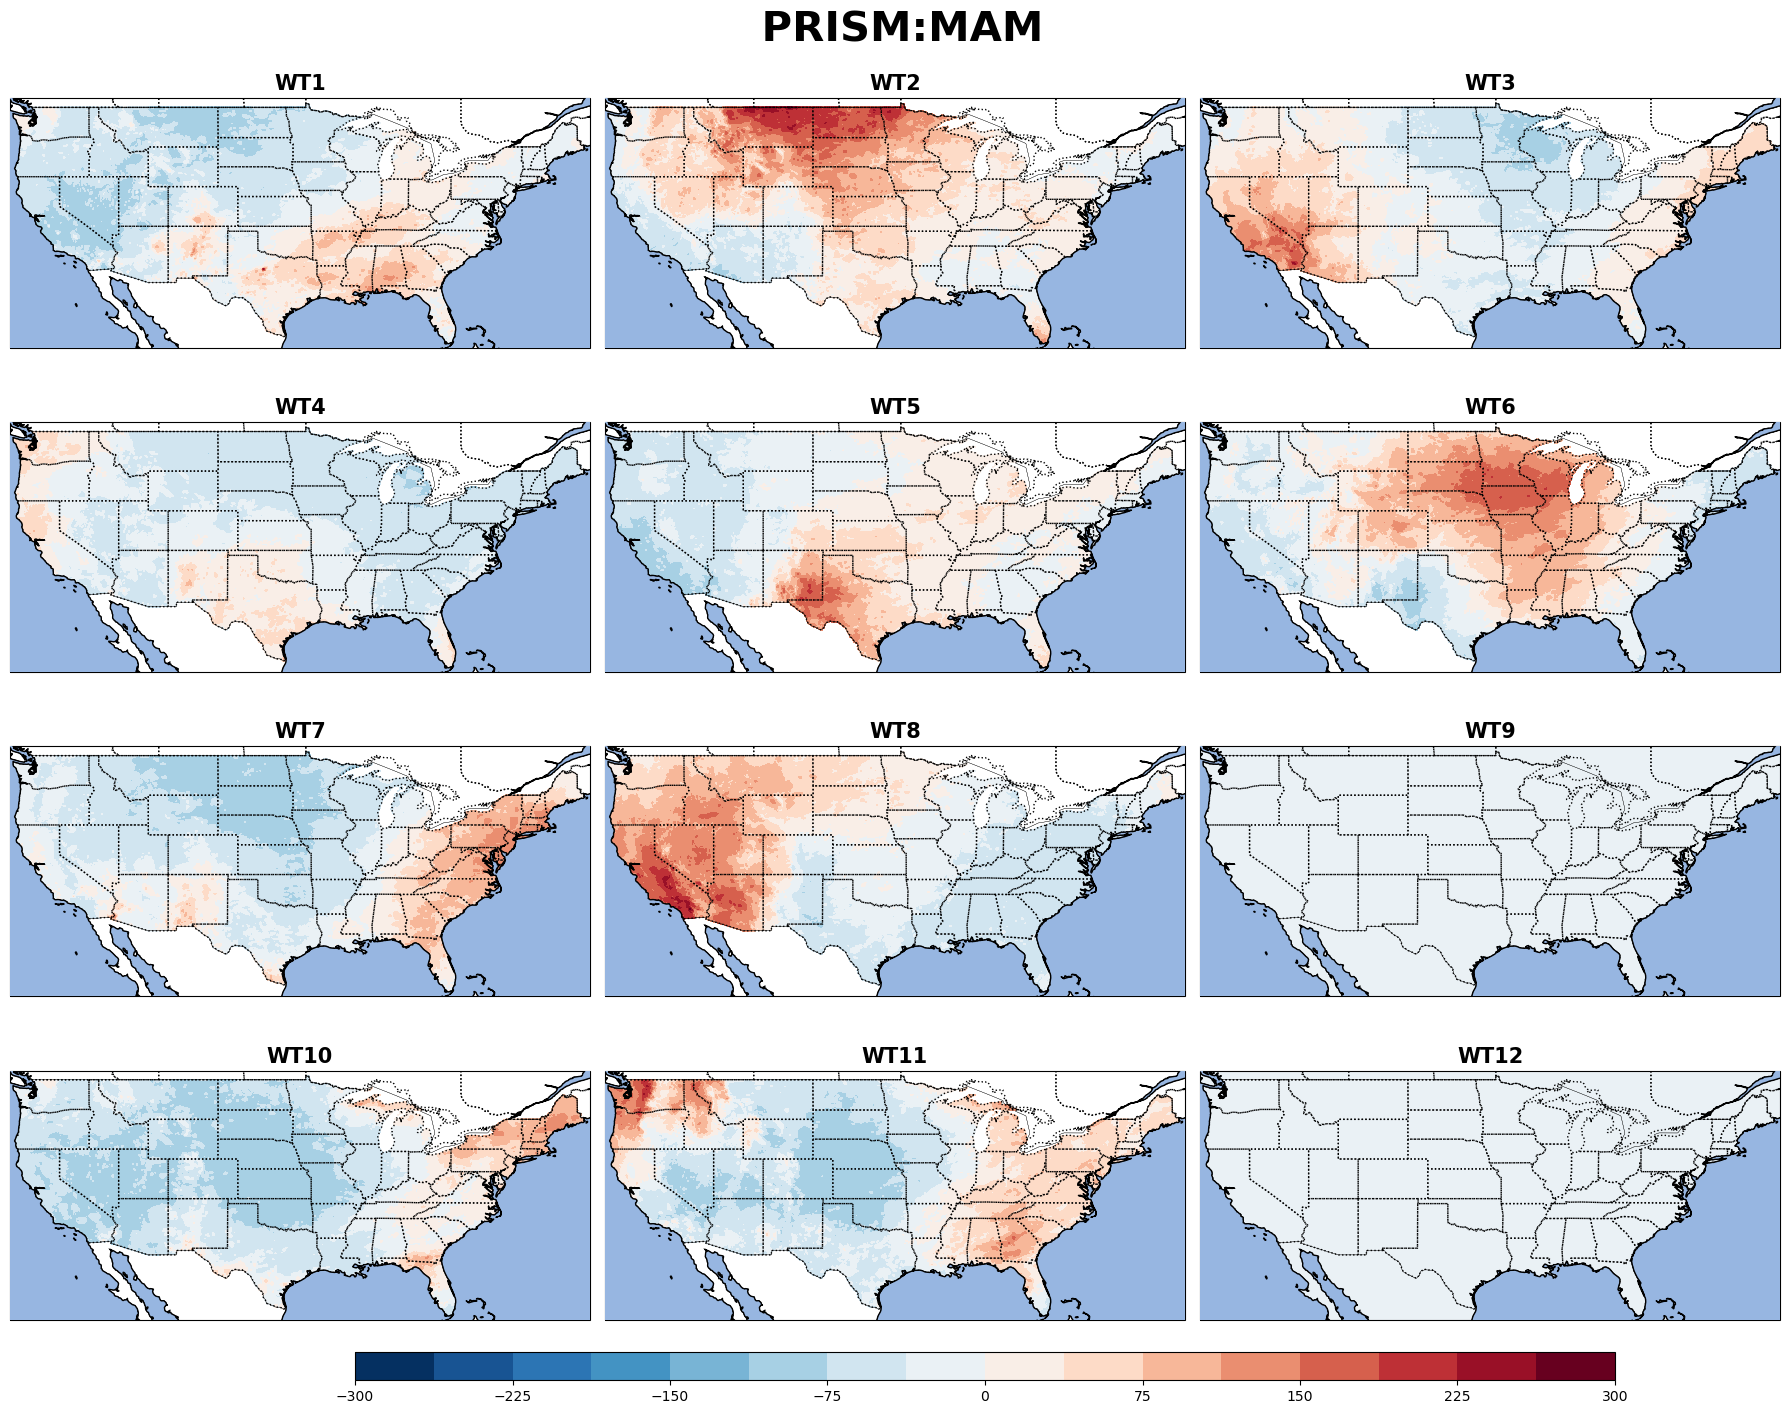

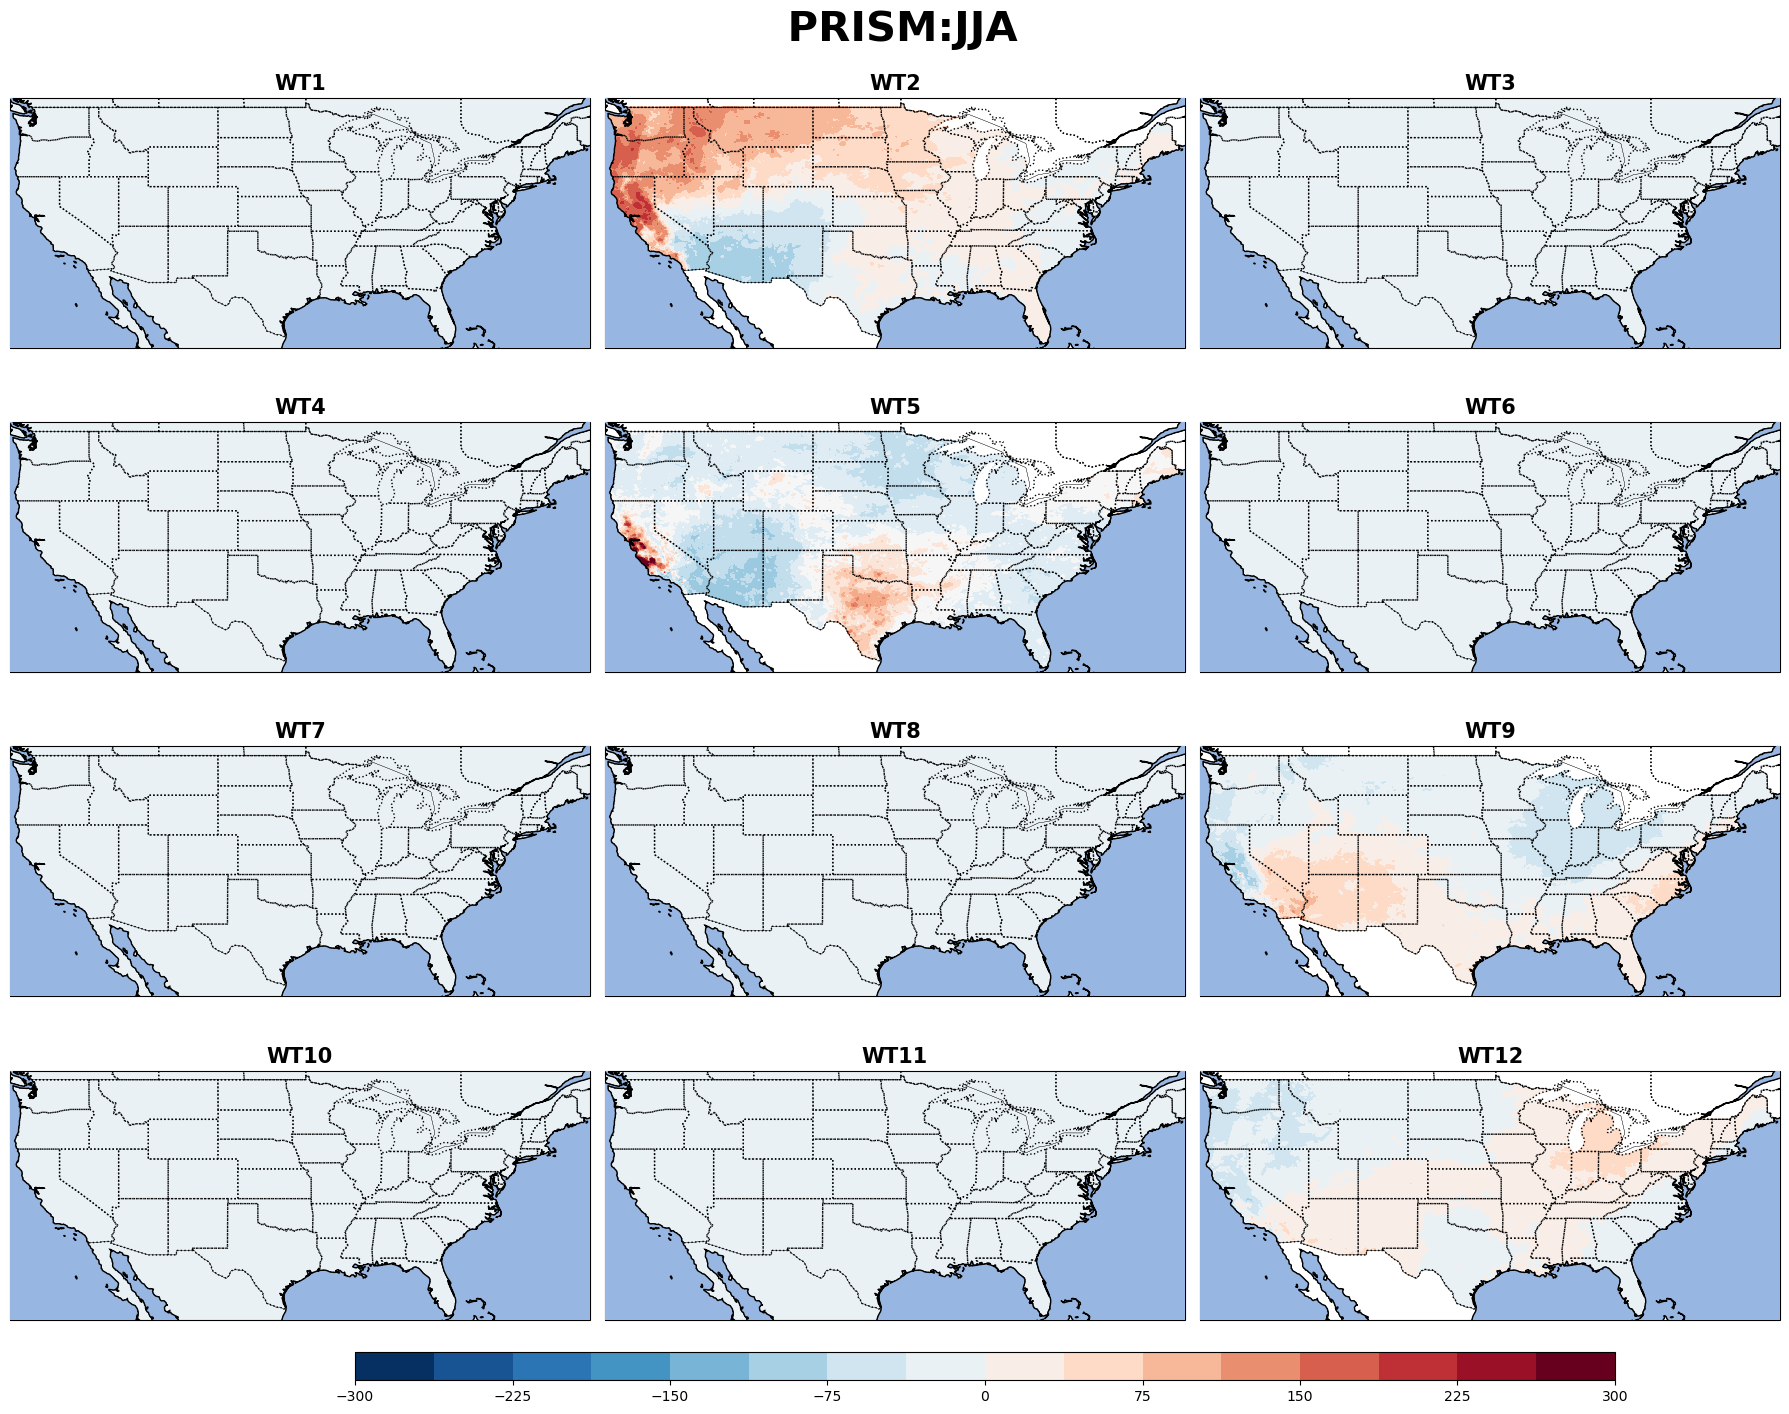

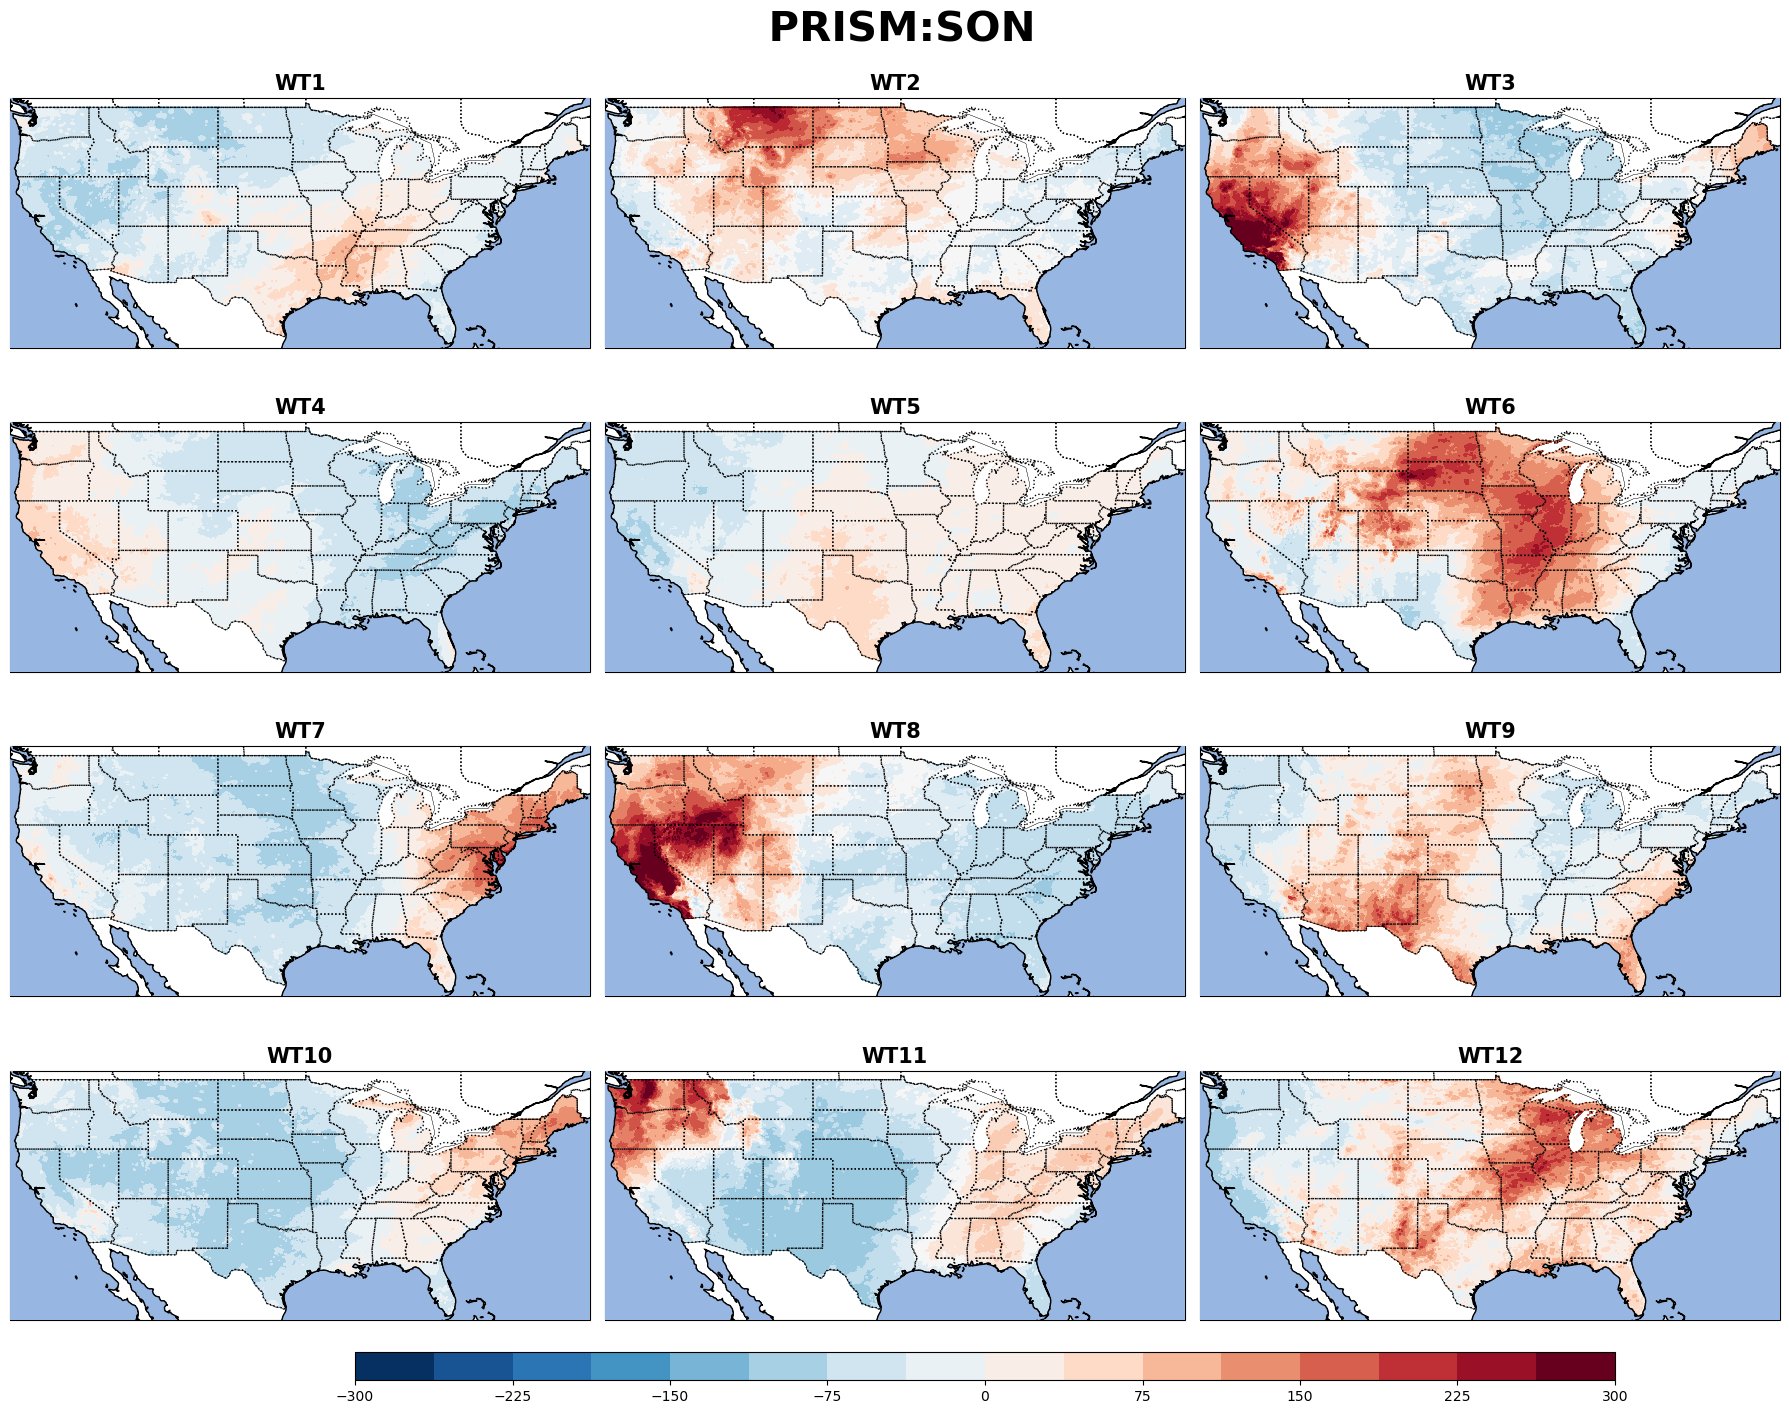

In [14]:
with  xr.open_dataset(flnm_o) as ds:
        # proj = ccrs.PlateCarree(central_longitude=180)
        # longitude from [-180, 180] -> [0,360]
        #ds.coords['longitude'] = xr.where(ds['longitude'] < 0, ds['longitude'] + 360, ds['longitude'])
        #ds = ds.sortby(ds.longitude)
        z500_wt = ds.__xarray_dataarray_variable__
         
season_s = ['DJF','MAM','JJA','SON']            

# Because proj = ccrs.PlateCarree(central_longitude=180)
# I need to convert longitude from [-180, 180] -> [0,360]
z500_wt.coords['longitude'] = xr.where(z500_wt['longitude'] < 0, z500_wt['longitude'] + 360, z500_wt['longitude'])
z500_wt = z500_wt.sortby(z500_wt.longitude)

# plot 4 seasons
for ns in range(4):
    plot_prec_12(z500_wt[:,ns]*100, -300, 300, 17, 'RdBu_r', 'horizontal', 'PRISM:' + season_s[ns]);